# Designing Communication Topologies via Graph Neural Networks
Fengjun Yang, Nikolai Matni (2021)

In [30]:
%load_ext autoreload
%autoreload 2

# Useful Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import control

# Source Files
import grnn, exp_utils, controller
import env.dlqr

# Other bookkeeping
%matplotlib inline
np.set_printoptions(precision=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## How to train and run the GRNN model

In [42]:
# Create an environment
N = 20
T = 50
p, q = 1, 1
degree = 5 + 1     # All nodes are assumed to have a self-loop, hence the +1

# Generate environment (here an LQR environment)
dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
#nx.draw_kamada_kawai(G)

In [43]:
# Define training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

In [44]:
# Create model
hidden_state_dim = 5
S = dlqrenv.S.clone()
model = grnn.GRNN(S, N, T, p, q, hidden_state_dim, S_trainable=True).to(device)

In [45]:
# Train model
model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=100, verbose=True)

Epoch: 1 	 Loss: 1073.8275741262473
Epoch: 11 	 Loss: 26.151142346215387
Epoch: 21 	 Loss: 25.29271913337343
Epoch: 31 	 Loss: 19.475387898423485
Epoch: 41 	 Loss: 27.123292333313838
Epoch: 51 	 Loss: 21.913543624785696
Epoch: 61 	 Loss: 28.68720481756307
Epoch: 71 	 Loss: 20.783879548353962
Epoch: 81 	 Loss: 25.055116928999333
Epoch: 91 	 Loss: 26.402120980916486


In [49]:
# Define controllers we want to compare to
lqrctrl = dlqrenv.get_optimal_controller()
grnnctrl = model.get_controller(batch_size=1)
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
controllers = [lqrctrl, grnnctrl, zeroctrl, randctrl]
names = ['Global Optimal', 'GRNN', 'Autonomous', 'Random']
exp_utils.estimate_grnn_cost(dlqrenv, model, T, [], 1000)

tensor([1.0000, 1.0872], dtype=torch.float64)

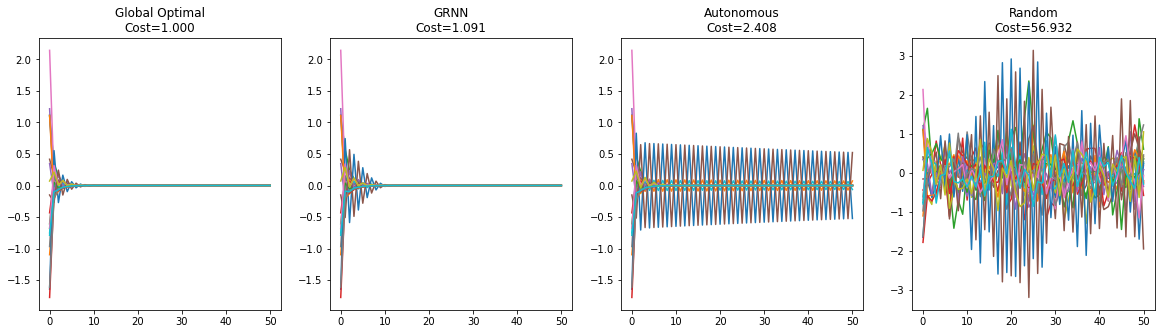

In [47]:
# Simulate each controller forward from the same initial condition
x0 = dlqrenv.random_x0()
xs, us, costs = exp_utils.sim_controllers(dlqrenv, x0, controllers, T, x0.device)
exp_utils.plot_controllers(xs.squeeze(1), names, costs, 0)

## What affects performance?

In [27]:
#smallsvs, Anorms, Bnorms, scores = [],[],[],[]

for counter in range(50):
    print(counter, end=',')
    dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
    AA = dlqrenv.A.numpy()
    BB = dlqrenv.B.numpy()
    smallsvs.append( min(np.linalg.svd(control.ctrb(AA, BB))[1]) )

    S = dlqrenv.S.clone()
    model = grnn.GRNN(S, N, T, p, q, hidden_state_dim, S_trainable=True).to(device)
    Anorms.append( np.linalg.norm(model.A.detach().numpy(), ord=2) )
    Bnorms.append( np.linalg.norm(model.B.detach().numpy(), ord=2) )
    model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=100, verbose=False)
    scores.append(exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1].item())

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

<IPython.core.display.Javascript object>


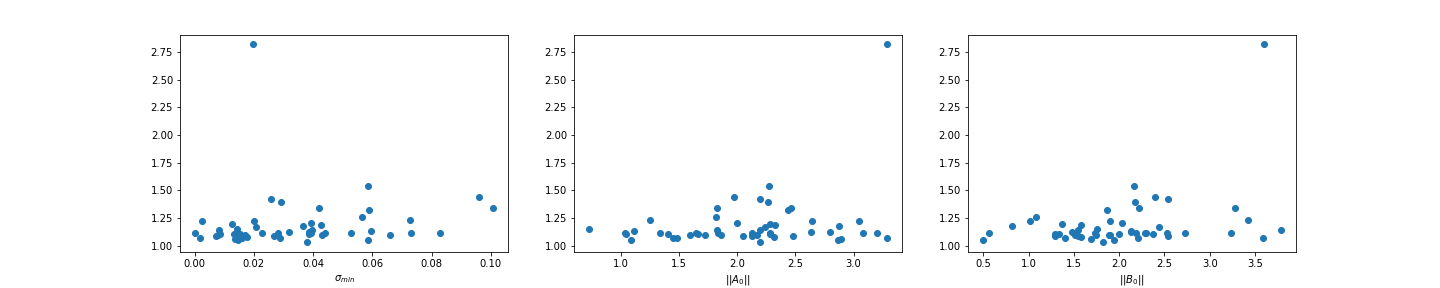

Average cost: 1.1948797011375427


In [26]:
plt.figure(figsize=(20, 4))
plt.subplot(1,3,1)
plt.scatter(smallsvs, scores)
plt.xlabel('$\sigma_{min}$')
plt.subplot(1,3,2)
plt.scatter(Anorms, scores)
plt.xlabel('$||A_0||$')
plt.subplot(1,3,3)
plt.scatter(Bnorms, scores)
plt.xlabel('$||B_0||$')
print('Average cost:', np.mean(scores))

<IPython.core.display.Javascript object>


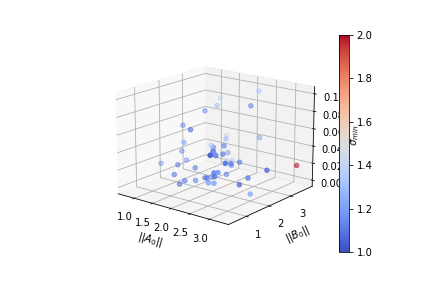

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cm_name = 'coolwarm'
cmap = matplotlib.cm.get_cmap(cm_name)
norm = plt.Normalize(vmin=1, vmax=2)
matplotlib.rc('image', cmap=cm_name)

colors = np.tile(np.log(scores),(3,1)).T
colors = colors / colors.max()
s = ax.scatter(Anorms, Bnorms, smallsvs, c=cmap(norm(scores)), cmap=cmap)
s.set_clim([1,2])
plt.xlabel('$||A_0||$')
plt.ylabel('$||B_0||$')
ax.set_zlabel('$\sigma_{min}$')
plt.colorbar(s)

## Experiment 1: GRNN on LQR Systems with Given Communication Topology

In [54]:
# Parameters for the model
N, degree, T, p, q, h = 20, 5+1, 50, 1, 1, 5
model_params = {'N':N,'T':T, 'p':p, 'q':p, 'h':5, 'S_trainable':True}

training_params = {
    'criterion': criterion, 'T': T, 'device': device,
    'num_epoch': 100, 'batch_size': 20, 'ensemble_size': 2, 'val_size': 50}
use_given_support = False

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

# Experiment parameters
num_topologies = 50
num_x0s = 100
num_epoch = 100
verbose = True

In [56]:
# Evaluate the performance of GRNN
total_rel_costs = torch.zeros(num_controllers, requires_grad=False)

rel_costs_table = torch.zeros((num_topologies, num_controllers), requires_grad=False)
envs = []

for counter in range(num_topologies):
    # Generate an environment
    dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
    model = exp_utils.generate_model(model_params, dlqrenv,
                                     use_given_support=use_given_support, S=dlqrenv.S.clone(),
                                     **training_params)
    
    # Test the performance of GRNN on this env
    rel_costs = exp_utils.estimate_grnn_cost(
        dlqrenv, model, T, additional_controllers, num_x0s=num_x0s)
    total_rel_costs += rel_costs
    
    rel_costs_table[counter] = rel_costs
    envs.append(dlqrenv)

    # Print progress
    if verbose:
        print('Iteration {}:\t{}\t{}'.format(counter+1, rel_costs, total_rel_costs / (counter+1)))

# Print result
print(total_rel_costs / num_topologies)

Iteration 1:	tensor([ 1.0000,  1.1313,  2.9913, 90.2063], dtype=torch.float64)	tensor([ 1.0000,  1.1313,  2.9913, 90.2063])
Iteration 2:	tensor([ 1.0000,  1.0962,  2.4902, 83.0832], dtype=torch.float64)	tensor([ 1.0000,  1.1138,  2.7408, 86.6448])
Iteration 3:	tensor([ 1.0000,  1.1725,  2.4912, 88.9047], dtype=torch.float64)	tensor([ 1.0000,  1.1334,  2.6576, 87.3981])
Iteration 4:	tensor([  1.0000,   1.2402,   2.6906, 100.7183], dtype=torch.float64)	tensor([ 1.0000,  1.1601,  2.6658, 90.7281])
Iteration 5:	tensor([ 1.0000,  1.1251,  2.3985, 58.6618], dtype=torch.float64)	tensor([ 1.0000,  1.1531,  2.6124, 84.3148])
Iteration 6:	tensor([ 1.0000,  1.2254,  2.3478, 63.2775], dtype=torch.float64)	tensor([ 1.0000,  1.1651,  2.5683, 80.8086])
Iteration 7:	tensor([ 1.0000,  1.0836,  1.8979, 61.1961], dtype=torch.float64)	tensor([ 1.0000,  1.1535,  2.4725, 78.0068])
Iteration 8:	tensor([ 1.0000,  1.1123,  2.3395, 52.0465], dtype=torch.float64)	tensor([ 1.0000,  1.1483,  2.4559, 74.7618])
Iter

## Experiment 2: Generate Communication Topology w/ GRNN

In [93]:
# Parameters for the model
N, degree, T, p, q, h = 20, 5+1, 50, 1, 1, 5
model_params = {'N':N,'T':T, 'p':p, 'q':p, 'h':5, 'S_trainable':True}

# Define Training loss
def sparse_criterion(x_traj, u_traj, env, model):
    global beta
    return env.cost(x_traj, u_traj) + beta * torch.sum(torch.abs(model.S_()))

def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

sparse_params = {
    'criterion': sparse_criterion, 'T': T, 'device': device,
    'num_epoch': 100, 'batch_size': 20, 'ensemble_size': 2, 'val_size': 50
}
training_params = {
    'criterion': criterion, 'T': T, 'device': device,
    'num_epoch': 100, 'batch_size': 20, 'ensemble_size': 2, 'val_size': 50
}

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Experiment parameters
verbose = True
threshold = 1e-3
betas = np.logspace(-5, 2, 10)

In [113]:
##################################
num_topologies = 2
threshold = 1e-3
##################################
num_edges = np.zeros(len(betas))
reg_costs = np.zeros(len(betas))
retrain_costs = np.zeros(len(betas))

for j in range(num_topologies):
    print('Topology: {}'.format(j))
    dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
    for i, beta in enumerate(betas):
        # Train on full support to get a model and topology
        grnn_S, model = exp_utils.grnn_topology(
            dlqrenv, model_params, sparse_params)
        reg_costs[i] += exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]

        # Retrain the model
        new_S = grnn_S.clone()
        new_S[new_S < threshold] = 0
        num_edges[i] += torch.sum(new_S > threshold).item()
        model = exp_utils.generate_model(model_params, dlqrenv, use_given_support=True,
                                         S=new_S, **training_params)
        retrain_costs[i] += exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]

num_edges = num_edges / num_topologies
reg_costs = reg_costs/ num_topologies
retrain_costs = retrain_costs/ num_topologies

print(num_edges)
print(reg_costs)
print(retrain_costs)

Topology: 0
Topology: 1
[380.  358.5 366.  376.5 362.5 358.  363.5 369.  358.5 362.5]
[ 6.32   1.608 46.683 45.768  1.521  1.109  5.293 25.77   1.302  1.269]
[159.984 104.594   2.782   1.981   1.694   1.226   2.511   1.196   1.107
  30.696]


Text(0, 0.5, 'LQR Cost')

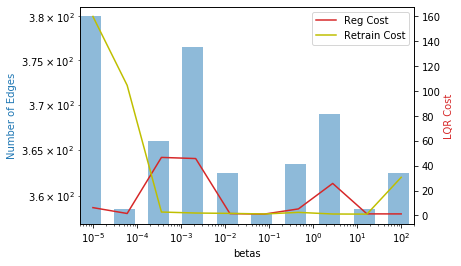

In [114]:
fig = plt.figure()
ax = plt.gca()

ax.bar(betas, num_edges, width=1*betas, log=True, alpha=0.5, color='tab:blue')
ax.set_xscale('log')
plt.xlim([betas[0]/2, betas[-1]*2])
ax.set_xlabel('betas')
ax.set_ylabel('Number of Edges', color='tab:blue')

ax2 = ax.twinx()
ax2.plot(betas, reg_costs, c='tab:red', label='Reg Cost')
ax2.plot(betas, retrain_costs, c='y', label='Retrain Cost')
ax2.legend()

ax2.set_ylabel('LQR Cost', color='tab:red')
#plt.savefig('losssparsity.png', dpi=300)

## Experiment 3: Unstable A

In [80]:
# Parameters for the model
N, degree, T, p, q, h = 20, 5+1, 50, 1, 1, 5
model_params = {'N':N,'T':T, 'p':p, 'q':p, 'h':5, 'S_trainable':True}

# Training loss
def stable_criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj) + env.instability_cost(x_traj, rho=.7)
stable_params = {
    'criterion': stable_criterion,'T': T,'device': device,'num_epoch': 100,'batch_size': 20,
    'ensemble_size': 2,'val_size': 50,
}

def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)
training_params = {
    'criterion': criterion,'T': T,'device': device,'num_epoch': 100,'batch_size': 20,
    'ensemble_size': 2,'val_size': 50,
}
use_given_support = True

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
additional_controllers = [zeroctrl]
num_controllers = len(additional_controllers) + 2

# Experiment parameters
num_topologies = 50
verbose = True
AB_norms = [1.05, 1.1]
num_x0s = 100

In [81]:
costs = np.zeros((len(AB_norms),3))

for i, norm in enumerate(AB_norms):
    print('-'*20, '\nNorm:', norm)
    
    # Evaluate the performance of GRNN
    total_rel_costs = np.zeros(4)
    stable_total_rel_costs = np.zeros(4)

    for counter in range(num_topologies):
        # Generate an environment
        dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device, A_norm=norm, B_norm=norm)
        model = exp_utils.generate_model(model_params, dlqrenv,
                                         use_given_support=use_given_support, S=dlqrenv.S.clone,
                                         **training_params)
        stable_model = exp_utils.generate_model(model_params, dlqrenv,
                                         use_given_support=use_given_support, S=dlqrenv.S.clone,
                                                **stable_params)

        # Test the performance of GRNN on this env
        rel_costs = exp_utils.estimate_grnn_cost(
            dlqrenv, model, T, [stable_model.get_controller()]+additional_controllers, num_x0s=num_x0s)
        
        total_rel_costs += rel_costs

        # Print progress
        if verbose:
            print('Iteration {}: {}\t{}'.format(counter+1, rel_costs, total_rel_costs/(counter+1)))

    costs[i] = total_rel_costs[1:] / (counter+1)

-------------------- 
Norm: 1.05
Iteration 1: [1.    1.083 1.088 9.928]	[1.    1.083 1.088 9.928]
Iteration 2: [ 1.     1.141  1.157 56.384]	[ 1.     1.112  1.122 33.156]
Iteration 3: [ 1.     1.317  1.298 52.489]	[ 1.     1.18   1.181 39.6  ]
Iteration 4: [ 1.     1.147  1.147 56.678]	[ 1.     1.172  1.172 43.87 ]
Iteration 5: [1.    1.268 1.416 4.312]	[ 1.     1.191  1.221 35.958]


KeyboardInterrupt: 

In [57]:
import json

In [59]:
json.load(open('./results/e2result1'))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [2]:
import json

In [3]:
data = json.load(open('./results/e2result2.json'))

In [4]:
num_edges = np.array(data['num_edges'])
reg_costs = np.array(data['reg_costs'])
retrain_costs = np.array(data['retrain_cost'])
env_edges = data['env_edges']

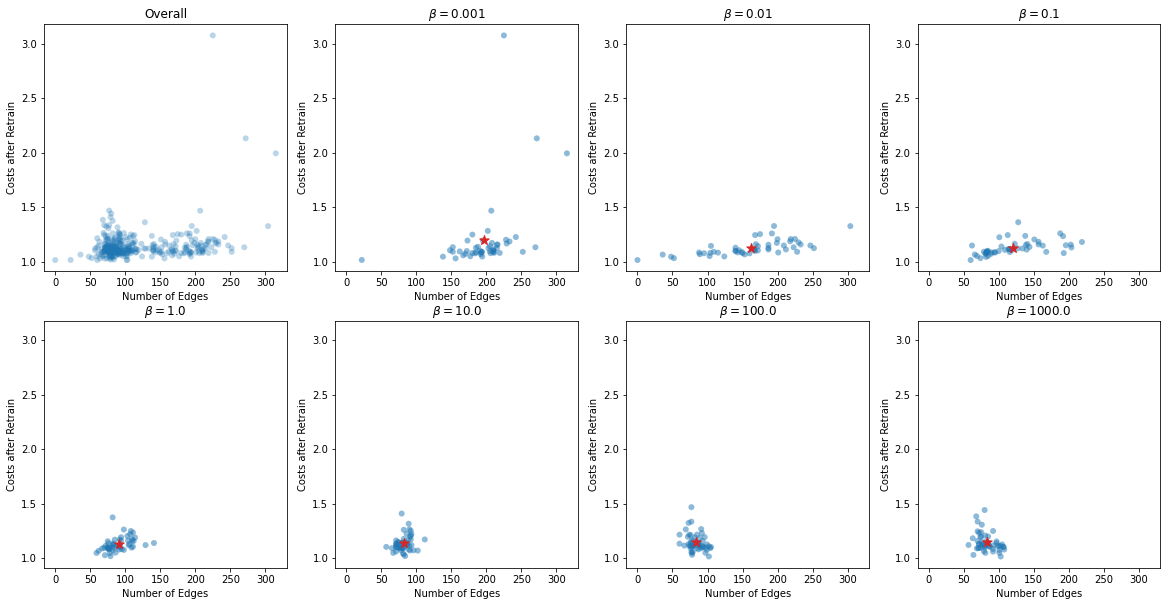

In [5]:
betas = np.logspace(-3, 3, 7)
plt.figure(figsize=(20, 10))
plt.title('Num Edges vs. Costs')

plt.subplot(2,4,1)
plt.scatter(num_edges.flatten(), retrain_costs.flatten(), c='tab:blue', alpha=0.3, edgecolors='none')
ax = plt.gca()
plt.title('Overall')
plt.xlabel('Number of Edges')
plt.ylabel('Costs after Retrain')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

for i in range(len(betas)):
  plt.subplot(2, 4, i+2)
  plt.scatter(num_edges[:,i], retrain_costs[:,i], c='tab:blue', alpha=0.5, edgecolors='none')
  plt.scatter(num_edges[:,i].mean(), retrain_costs[:,i].mean(), c='tab:red', marker='*', s=100)
  plt.xlim([xmin, xmax])
  plt.ylim([ymin, ymax])
  plt.xlabel('Number of Edges')
  plt.ylabel('Costs after Retrain')
  plt.title(r'$\beta={}$'.format(betas[i]))
plt.savefig('beta dist.png', dpi=200)

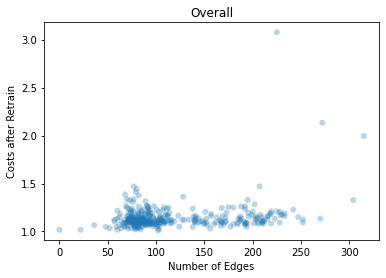

In [6]:
plt.scatter(num_edges.flatten(), retrain_costs.flatten(), c='tab:blue', alpha=0.3, edgecolors='none')
ax = plt.gca()
plt.title('Overall')
plt.xlabel('Number of Edges')
plt.ylabel('Costs after Retrain')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

<ErrorbarContainer object of 3 artists>

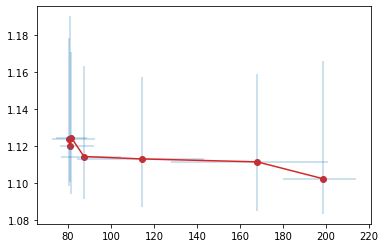

In [29]:
median_edges = np.median(num_edges, axis=0)
median_costs = np.median(retrain_costs, axis=0)
plt.scatter(median_edges, median_costs, c='tab:red')
plt.plot(median_edges, median_costs, c='tab:red')
#yerr = retrain_costs.std(0)
#xerr = num_edges.std(0)
edge_lower = np.quantile(num_edges, 0.25, axis=0)
edge_upper = np.quantile(num_edges, 0.75, axis=0)
edge_err = np.vstack([median_edges - edge_lower, edge_upper - median_edges])
cost_lower = np.quantile(retrain_costs, 0.25, axis=0)
cost_upper = np.quantile(retrain_costs, 0.75, axis=0)
cost_err = np.vstack([median_costs - cost_lower, cost_upper - median_costs])
plt.errorbar(median_edges,median_costs, xerr=edge_err, yerr=cost_err, linestyle="None", alpha=0.3)

In [57]:
H1 = torch.randn(5,1,32)

In [66]:
X = torch.randn(5, 20, 1)
S = torch.eye(20) * 2

In [67]:
(S @ X @ H1[0]).shape

torch.Size([5, 20, 32])

In [73]:
import gcnn

In [109]:
dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
S = dlqrenv.S.clone()

In [114]:
gcnn_model = gcnn.GCNN(S, N, T)
gcnn_model = exp_utils.train_model(gcnn_model, dlqrenv, criterion, num_epoch=100, lr=.01, verbose=True)
exp_utils.estimate_grnn_cost(dlqrenv, gcnn_model, T, [], 1000)

Epoch: 1 	 Loss: 130605.31277877596
Epoch: 11 	 Loss: 3103.9886871911776
Epoch: 21 	 Loss: 59.77940956185434
Epoch: 31 	 Loss: 45.35134714509951
Epoch: 41 	 Loss: 38.05725256636593
Epoch: 51 	 Loss: 32.30279077503068
Epoch: 61 	 Loss: 36.606384543897924
Epoch: 71 	 Loss: 29.758875841757003
Epoch: 81 	 Loss: 33.96561265013371
Epoch: 91 	 Loss: 33.425143391473306


tensor([1.0000, 1.2173], dtype=torch.float64)

In [116]:
gcnn_model = exp_utils.generate_gcnn_model(dlqrenv.S, N, T, dlqrenv, criterion, device)
exp_utils.estimate_grnn_cost(dlqrenv, gcnn_model, T, [], 1000)

tensor([1.0000, 1.1894], dtype=torch.float64)

In [112]:
grnn_model = grnn.GRNN(S, N, T, p, q, hidden_state_dim, S_trainable=True).to(device)
grnn_model = exp_utils.train_model(grnn_model, dlqrenv, criterion, num_epoch=100, lr=.03, verbose=True)
exp_utils.estimate_grnn_cost(dlqrenv, grnn_model, T, [], 1000)

Epoch: 1 	 Loss: 104007.95731087492
Epoch: 11 	 Loss: 56.12142308162195
Epoch: 21 	 Loss: 37.30304460153284
Epoch: 31 	 Loss: 34.56863498059282
Epoch: 41 	 Loss: 35.05375946402663
Epoch: 51 	 Loss: 32.75948787089758
Epoch: 61 	 Loss: 30.684875618617998
Epoch: 71 	 Loss: 28.854565307871788
Epoch: 81 	 Loss: 31.630647494411328
Epoch: 91 	 Loss: 29.50857679263246


tensor([1.0000, 1.1474], dtype=torch.float64)

In [96]:
lqrctrl = dlqrenv.get_optimal_controller()
grnnctrl = model.get_controller(batch_size=1)
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
controllers = [lqrctrl, grnnctrl, zeroctrl, randctrl]
names = ['Global Optimal', 'GRNN', 'Autonomous', 'Random']

tensor([1.0000, 1.4966], dtype=torch.float64)

In [121]:
from experiments import exp1

In [122]:
a = [1]

In [123]:
a = a + [2]

In [125]:
a = [3] + a

In [126]:
a

[3, 1, 2]

In [141]:
from experiments import exp1

In [142]:
exp1.run()

KeyboardInterrupt: 